# Homework 2

## FINM 37400 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [77]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
from treasury_cmds import *
pd.options.display.float_format = '{:,.6f}'.format

In [78]:
treasury_path = 'C:/Users/dcste/OneDrive/fixed_income/fixed_income_FORKED/finm-fixedincome-2023/data/treasury_ts_2015-08-15.xlsx'
t_path_2 = 'C:/Users/dcste/OneDrive/fixed_income/fixed_income_FORKED/finm-fixedincome-2023/data/treasury_quotes_2022-09-30.xlsx'
info = pd.read_excel(treasury_path, sheet_name='info', index_col = 0)
ts_data = pd.read_excel(treasury_path, sheet_name= 'database')
ts_data.columns = ts_data.columns.str.upper()
treasury_df = pd.read_excel(t_path_2)
treasury_df.columns = treasury_df.columns.str.upper()
treasury_df.sort_values('TMATDT', inplace=True)
treasury_df.set_index("KYTREASNO", inplace = True)


In [79]:
mask = ts_data[ts_data.CALDT == '2008-11-04']
metrics = mask.copy()[['KYTREASNO','CALDT','TDBID','TDASK','TDNOMPRC','TDACCINT', 'TDYLD','TDDURATN','TDPUBOUT']].set_index('KYTREASNO')
metrics.columns = ['CALDT','BID','ASK', 'Nominal_Price','Accrued Interest','YTM','Duration','Outstanding']

In [80]:
metrics['Dirty_Price'] = (metrics['BID']+metrics['ASK'])*.5 + metrics['Accrued Interest']

In [81]:
metrics['YTM'] *= 365.25
metrics['Coupon_Rate'] = [4.25,10.625]
metrics['Duration'] /= 365.25
metrics['Modified Duration'] = metrics['Duration']/(1+(metrics['YTM']/2))
metrics['Dollar_Duration'] = metrics['Modified Duration']*metrics['Dirty_Price']
metrics = metrics.T

In [82]:
metrics

KYTREASNO,204047,204046
CALDT,2008-11-04 00:00:00,2008-11-04 00:00:00
BID,105.953125,141.859375
ASK,105.984375,141.890625
Nominal_Price,105.968750,141.875000
Accrued Interest,0.935462,2.338655
YTM,0.032362,0.035753
Duration,5.935706,5.230138
Outstanding,"20,998.000000","2,852.000000"
Dirty_Price,106.904212,144.213655
Coupon_Rate,4.250000,10.625000


In [83]:
trade_pair = pd.DataFrame(data = None, columns=['204047','204046'])
trade_pair.loc['YTM'] = [0.032362,0.035753]
trade_pair.loc['Dirty_Price']  = [106.904212,144.213655]

trade_pair.loc['Modified_Duration'] = [5.841189,5.13824]
trade_pair.loc['dollar_duration'] = [624.447664,741.010749]

In [84]:
trade_pair

,204047,204046
YTM,0.032362,0.035753
Dirty_Price,106.904212,144.213655
Modified_Duration,5.841189,5.138240
dollar_duration,624.447664,741.010749


In [85]:
long_security = trade_pair.loc['YTM'].idxmax()
short_security = trade_pair.loc['YTM'].idxmin()

short_security

'204047'

In [86]:
p = trade_pair.loc['Dirty_Price']
p.loc['204046']

144.213655

# Calculating Hedge Ratio

## Financing Assumptions

- In this trade we take a long position in the bond which has the higher yield and short the note that has a lower yield.

In [87]:
def hedge_ratio(dollar_duration_long, dollar_duration_short, size_long = None):
    if size_long == None:
        return -dollar_duration_long/dollar_duration_short
    else:
        return (-size_long*(dollar_duration_long))/dollar_duration_short

In [101]:
LONG_EQUITY = 1e6
def trade_balance_sheet(prices, durations, haircuts, long_equity, short_equity):
    balance_sheet = pd.DataFrame(data = None,columns=['Equity','Asset_Value','Contracts','Dollar_Duration','Dirty_Price'], index = [long_equity,short_equity])
    long_price = prices.loc[long_equity]
    short_price = prices.loc[short_equity]
    duration_long = durations.loc[long_equity]
    duration_short = durations.loc[short_equity]
    haircut_short = haircuts.loc['short']
    haircut_long = haircuts.loc['long']
    balance_sheet.loc[long_equity,'Dollar_Duration'] = duration_long
    balance_sheet.loc[short_equity,'Dollar_Duration'] = duration_short
    balance_sheet.loc[long_equity,'Equity'] = LONG_EQUITY
    balance_sheet.loc[long_equity,'Asset_Value'] = 5e7
    balance_sheet.loc[long_equity,'Contracts'] = balance_sheet.loc[long_equity,'Asset_Value']/long_price
    balance_sheet.loc[short_equity,'Contracts'] = hedge_ratio(dollar_duration_long=duration_long,dollar_duration_short=duration_short,\
        size_long=balance_sheet.loc[long_equity,'Contracts'])
    balance_sheet.loc[short_equity,'Asset_Value'] = balance_sheet.loc[short_equity,'Contracts']*short_price
    balance_sheet.loc[short_equity,'Equity'] = balance_sheet.loc[short_equity,'Asset_Value']*haircut_short
    balance_sheet.loc[short_equity,'Dirty_Price'] = short_price
    balance_sheet.loc[long_equity,'Dirty_Price'] = long_price
    
    return balance_sheet
    
    

In [102]:
financing = pd.DataFrame(dtype='float64',index=['long','short'])
financing['haircut'] = [.02,.02]
financing['repo'] = [.0015,.0010]
financing

,haircut,repo
long,0.020000,0.001500
short,0.020000,0.001000


In [103]:
balance_sheet = trade_balance_sheet(prices=trade_pair.loc['Dirty_Price'], durations=trade_pair.loc['dollar_duration'],haircuts = financing['haircut'],\
   long_equity = long_security, short_equity = short_security )


In [104]:
spread_df = ts_data.pivot_table(values='TDYLD', index = 'CALDT',columns='KYTREASNO')
spread_df.columns = ['204046','204047','206524']
spread_df['206524'] = spread_df['204046']- spread_df['204047']
spread_df = spread_df.rename(columns={'206524':'Spread'})
# I need to format the yields
spread_df *= 365.25
spread_df = spread_df.loc['2006':,:]

(-0.001, 0.008)

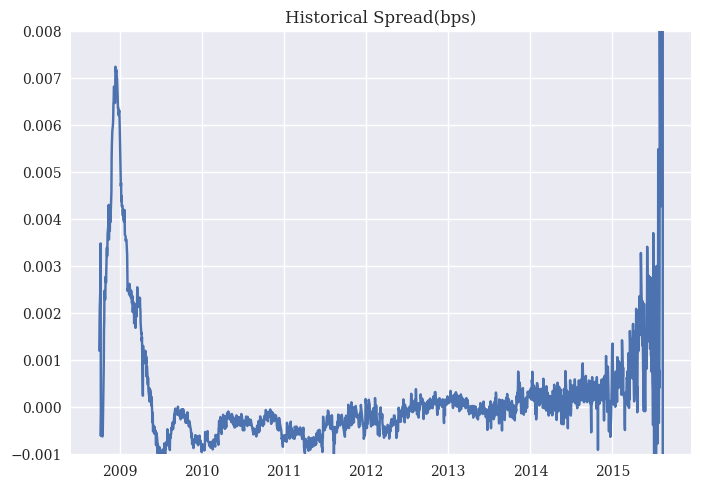

In [105]:
plt.plot(spread_df.loc['2008-10':,'Spread'])
plt.title('Historical Spread(bps)')
plt.ylim(-.001,.008)

In [93]:
(spread_df*100).describe()

,204046,204047,Spread
count,"2,410.000000","2,410.000000","2,410.000000"
mean,2.009363,1.990174,0.019189
std,1.719906,1.709289,0.182395
min,-6.077314,0.007719,-6.085032
25%,0.353566,0.345058,-0.026247
50%,1.727539,1.718937,0.001298
75%,3.465700,3.398835,0.020286
max,5.221068,5.229953,2.657635


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 


## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

## 1.5 *Optional*: Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

In [94]:
trade_pair

,204047,204046
YTM,0.032362,0.035753
Dirty_Price,106.904212,144.213655
Modified_Duration,5.841189,5.138240
dollar_duration,624.447664,741.010749


In [100]:
spread_convergence = .0001

trade_pair.loc['YTM'].idxmax()

'204046'

In [131]:
def duration_pnl(dollar_duration, delta_rate, no_contracts):
    delta_bond_price = -dollar_duration*delta_rate
    PNL = no_contracts*delta_bond_price
    return PNL

In [108]:
balance_sheet

,Equity,Asset_Value,Contracts,Dollar_Duration,Dirty_Price
204046,"1,000,000.000000","50,000,000.000000","346,707.806553",741.010749,144.213655
204047,"-879,664.154632","-43,983,207.731591","-411,426.331187",624.447664,106.904212


In [143]:
def pnl_spread_trade(spread_conv, dollar_duration,prices,size_pos, long_equity, short_equity):
    spread_conv /= 2
    pnl_df = pd.DataFrame(data = None, index = [long_equity,short_equity,'total'])
    long_price = prices.loc[long_equity]

    short_price = prices.loc[short_equity]
    
    long_d_duration = dollar_duration.loc[long_equity]
    short_d_duration = dollar_duration.loc[short_equity]
    no_contracts_long = size_pos.loc[long_equity]
    no_contracts_short = size_pos.loc[short_equity]
    pnl_df.loc[long_equity,'YTM_Change'] = -spread_conv
    pnl_df.loc[short_equity,'YTM_Change'] = spread_conv
    pnl_df.loc[long_equity,'Dollar_Duration'] = long_d_duration
    pnl_df.loc[short_equity,'Dollar_Duration'] = short_d_duration
    pnl_df.loc[long_equity,'Contracts'] = no_contracts_long
    pnl_df.loc[short_equity,'Contracts'] = no_contracts_short
    pnl_df.loc[long_equity,'PNL'] = duration_pnl(long_d_duration,-spread_conv,no_contracts_long)
    pnl_df.loc[short_equity,'PNL'] = duration_pnl(short_d_duration,spread_conv,no_contracts_short)
    pnl_df.loc['total','PNL'] = pnl_df['PNL'].sum()
    return pnl_df.fillna(0)

   





In [117]:
balance_sheet.Dirty_Price

204046   144.213655
204047   106.904212
Name: Dirty_Price, dtype: object

In [156]:
# if the spread converges by 1 basis point you are projected to make $25,000
pnl_1bs = pnl_spread_trade(spread_convergence,balance_sheet.Dollar_Duration,balance_sheet.Dirty_Price,balance_sheet.Contracts,long_security,short_security)

In [160]:
pnl_1bs

,YTM_Change,Dollar_Duration,Contracts,PNL
204046,-0.000050,741.010749,"346,707.806553","12,845.710571"
204047,0.000050,624.447664,"-411,426.331187","12,845.710571"
total,0.000000,0.000000,0.000000,"25,691.421142"


In [161]:
pnl_1bs.loc['total','PNL']


25691.421141777464

# Calculating the PNL on 2008-11-25 and 2008-12-16



In [166]:

pnl_spread_trade(st1,balance_sheet.Dollar_Duration,balance_sheet.Dirty_Price,balance_sheet.Contracts,long_security,short_security)

,YTM_Change,Dollar_Duration,Contracts,PNL
204046,0.000955,741.010749,"346,707.806553","-245,234.069145"
204047,-0.000955,624.447664,"-411,426.331187","-245,234.069145"
total,0.000000,0.000000,0.000000,"-490,468.138290"


In [167]:
st1 = -(spread_df.loc['2008-11-25']['Spread']-spread_df.loc['2008-11-04']['Spread'])
st2 = -(spread_df.loc['2008-12-16']['Spread'] - spread_df.loc['2008-11-04']['Spread'])

In [168]:
pnl_spread_trade(st2,balance_sheet.Dollar_Duration,balance_sheet.Dirty_Price,balance_sheet.Contracts,long_security,short_security)

,YTM_Change,Dollar_Duration,Contracts,PNL
204046,0.001888,741.010749,"346,707.806553","-485,037.913422"
204047,-0.001888,624.447664,"-411,426.331187","-485,037.913422"
total,0.000000,0.000000,0.000000,"-970,075.826844"


***

# 2 Calculating Duration

Use the data file `../data/treasury_quotes_2022-09-30.xlsx`.

This data reports duration as `TDDURATN`. It quotes the duration in days, so I recommend dividing by 365 to get the duration in its usual format.

## 2.1 
Set up the cashflow matrix. 


## 2.2
Build a discount curve assuming that the spot rate is 2\% per year, continuously compounded.

Plot the discount curve and the associated spot curve out to 30 years maturity.

*Note, you do not need to properly extract a spot curve and associated discount factors; rather, you are simply assuming a flat term structure of spot rates at 2\% and using that to figure out discount rates.*

## 2.3
For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use `.describe()` from pandas.)


## 2.4
How close are your duration estimates to the imputed durations given in the data source, (column `TDDURATN`)?

Report the summary statistics of the imputed durations minus your calculated durations from above.

Why might they be different?

## 2.5
Continue using your assumed discount rates of 2\% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.

## 2.6 (Optional)

Re-do the duration and convexity calculations using an extracted discount curve instead of a discount curve based on a constant (arbitrary) spot rate. 

In [177]:
t_current = treasury_df.CALDT.values[0]
rawprice = (treasury_df['TDASK']+ treasury_df['TDBID'])*.5 + treasury_df['TDACCINT']
rawprice.name = 'Prices'

In [179]:
maturity_delta = get_maturity_delta(treasury_df.TMATDT,t_current=t_current)


In [181]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False
treasury_filtered = filter_treasuries(treasury_df, t_date=t_current, filter_yld=RESTRICT_YLD,\
    filter_tips=RESTRICT_TIPS,drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(treasury_filtered), filter_maturity_dates=RESTRICT_DTS_MATURING)

In [182]:
CF

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.000000,0,0,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
207774,0,100,0,0,0.000000,0,0,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
207893,0,0,100,0,0.000000,0,0,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
207868,0,0,0,100,0.000000,0,0,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
207430,0,0,0,0,100.687500,0,0,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.000000,0,0,0,0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,101.000000,0.000000,0.000000,0.000000,0.000000
207808,0,0,0,0,0.000000,0,0,0,0,0.000000,...,0.937500,0.000000,0.937500,0.000000,0.937500,0.000000,100.937500,0.000000,0.000000,0.000000
207849,0,0,0,0,0.000000,0,0,0,0,0.000000,...,0.000000,1.125000,0.000000,1.125000,0.000000,1.125000,0.000000,101.125000,0.000000,0.000000


Text(0.5, 1.0, 'Discount Factor ')

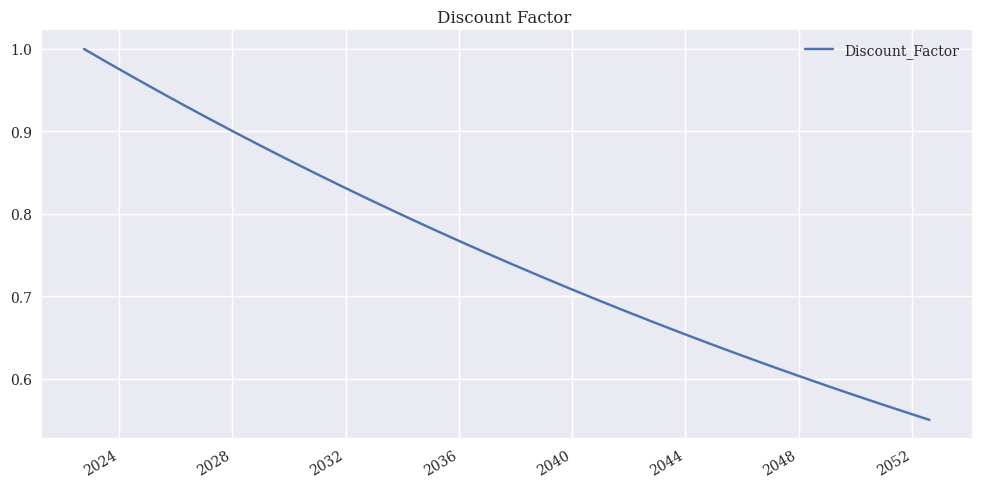

In [192]:
RATE = 0.02
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current), index = CF.columns)
discount_factors = np.exp(-RATE*maturity_grid)
curve = pd.DataFrame(discount_factors,index = CF.columns, columns=['Discount_Factor'])
curve.plot(figsize=(12,6))
plt.title('Discount Factor ')

In [196]:
weight = CF

2022-10-04   0.999781
2022-10-06   0.999672
2022-10-11   0.999398
2022-10-13   0.999288
2022-10-15   0.999179
               ...   
2051-08-15   0.561318
2051-11-15   0.558498
2052-02-15   0.555691
2052-05-15   0.552959
2052-08-15   0.550181
Name: Discount_Factor, Length: 312, dtype: float64

In [197]:
print(CF.shape,curve.shape)

(378, 312) (312, 1)


In [215]:
weight = CF.mul(curve['Discount_Factor'], axis  = 1)
#divide each present value of CF by the present value of the bond
weight = weight.div(weight.sum(axis =1),axis = 0)


In [217]:
print(weight.shape, maturity_grid.shape)

(378, 312) (312,)


In [223]:
duration = weight@maturity_grid.to_frame().rename(columns={0:'Duration'})

In [227]:
duration


,Duration
KYTREASNO,
207892,0.010951
207774,0.016427
207893,0.030116
207868,0.035592
207430,0.041068
...,...
207763,22.009445
207808,22.292807
207849,21.825479


In [234]:
freq = 365.25
dif = pd.DataFrame(treasury_df['TDDURATN']/365.25 - duration['Duration'], columns=['Difference'])

In [235]:
dif.describe()

,Difference
count,378.000000
mean,-0.212790
std,0.469856
min,-1.958441
25%,-0.034362
50%,-0.002948
75%,-0.000018
max,0.000037


# Calculating Convexity


In [238]:
duration['Convexity'] = weight@(maturity_grid**2)

In [239]:
duration

,Duration,Convexity
KYTREASNO,,
207892,0.010951,0.000120
207774,0.016427,0.000270
207893,0.030116,0.000907
207868,0.035592,0.001267
207430,0.041068,0.001687
...,...,...
207763,22.009445,574.894240
207808,22.292807,589.750695
207849,21.825479,573.468303


# 3 Hedging Duration

Import `treasury_ts_issue_duration_(207392, 207391, 207457).xlsx`.

I suggest using code such as

* `tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')`

* `tsdata.columns = tsdata.columns.str.upper()`

* `px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()`
* `duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()`

## 3.1 

Suppose you have a portfolio of 10,000 USD long in security `207391` on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

(Duration is the column `TDDURATN` in the raw data.)

## 3.2

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be 10,000.
* Repeat throughout the timeseries.

Report 
* the total profit (or loss.)
* the mean, standard deviation, min, and max of the daily profit or loss.

In [243]:
ts_q3_path = 'C:/Users/dcste/OneDrive/fixed_income/fixed_income_FORKED/finm-fixedincome-2023/data/treasury_ts_issue_duration_(207392, 207391, 207457).xlsx'
treasury_ts_info = pd.read_excel(ts_q3_path, sheet_name='info').set_index('kytreasno')
treasury_ts_data = pd.read_excel(ts_q3_path,sheet_name='ts')

In [302]:
size = 1e4
IDLONG = 207391
IDSHORT = 207392
FREQ = 365.25

In [303]:
treasury_ts_info

,issue date,maturity date,coupon rate,security type
kytreasno,,,,
207392,2019-08-15,2049-08-15,2.250000,1
207391,2019-08-15,2029-08-15,1.625000,2
207457,2019-12-15,2022-12-15,1.625000,2


In [304]:
treasury_ts_data.columns = treasury_ts_data.columns.str.upper()
px = treasury_ts_data.pivot_table(index = 'CALDT',columns = 'KYTREASNO',values = 'TDASK').dropna().drop(columns=207457)
duration = (treasury_ts_data.pivot_table(index = 'CALDT',columns='KYTREASNO',values = 'TDDURATN').dropna().drop(columns=207457))/FREQ

In [305]:
position = pd.DataFrame(index = duration.index, dtype='float')
position['long'] = size/px[IDLONG]
position['Hedge_Ratio'] = (duration[IDLONG]/duration[IDSHORT])*(px[IDLONG]/px[IDSHORT])
position['short'] = -position['Hedge_Ratio']*position['long']
position[['long ($)','short ($)']] = position[['long','short']]*px[[IDLONG,IDSHORT]].values

In [306]:
position['net ($)'] = position[['long ($)','short ($)']].sum(axis = 1)
wts = position[['long ($)', 'short ($)']].div(position[['long ($)', 'short ($)']].sum(axis = 1), axis = 0)
position['duration'] = (wts*duration[[IDLONG,IDSHORT]].values).sum(axis = 1)
position[['duration']].describe()

,duration
count,621.000000
mean,-0.000000
std,0.000000
min,-0.000000
25%,-0.000000
50%,0.000000
75%,0.000000
max,0.000000


In [314]:
position[['long ($) realized', 'short ($) realized']] = \
    position[['long','short']]*px[[IDLONG,IDSHORT]].shift(-1).values
position[['long pnl', 'short pnl']] = position[['long ($) realized', 'short ($) realized']] - position[['long ($)', 'short ($)']].values
position['profit ($) hedge'] = position['long pnl'] + position['short pnl']
position['profit'] = px[IDLONG].diff() *px[IDLONG].shift()

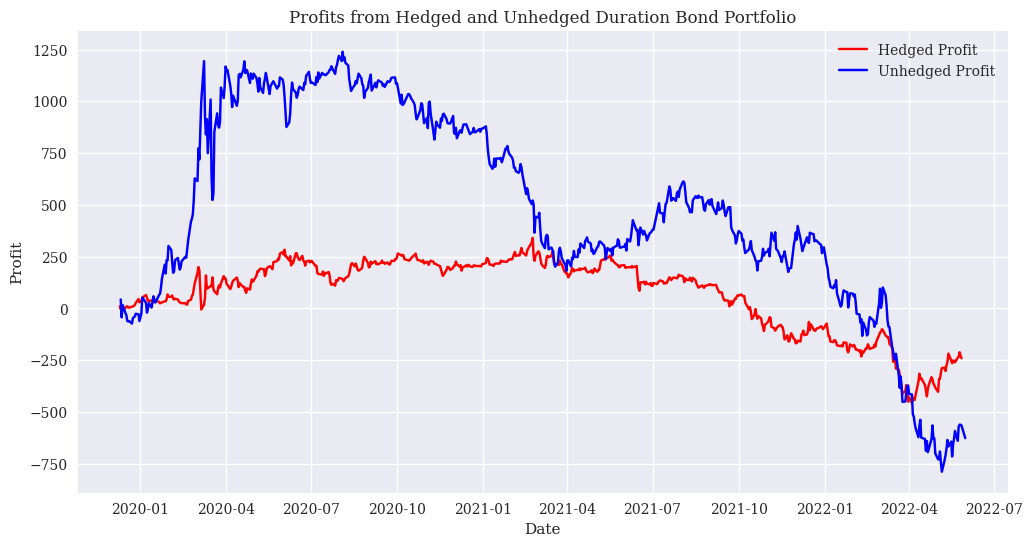

In [323]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(position['profit ($) hedge'].cumsum(), color = 'red', label ='Hedged Profit')
ax.plot(position['profit'].cumsum(), color = 'blue',label = 'Unhedged Profit')
ax.set_ylabel('Profit')
ax.set_xlabel('Date')
ax.set_title('Profits from Hedged and Unhedged Duration Bond Portfolio')
ax.legend()



In [325]:
position[['profit ($) hedge','profit']].describe()

,profit ($) hedge,profit
count,620.000000,620.000000
mean,-0.388564,-1.010402
std,18.797647,47.651475
min,-98.317955,-374.706299
25%,-9.776653,-26.452835
50%,-0.077860,-1.345947
75%,9.250157,24.240128
max,107.636148,297.649902


***

# 4 Other Interest-Rate Risks

## *Optional*

***No need to submit this problem, but if we discuss it, then you are expected to know it.***

## 4.1 Other Yield Curve Movements

Use the yield curve time-series data in `'../data/yields_2022-11-30.xlsx` to calculate the time-series of the **level**, **slope**, and curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}

Report the mean and volatility of each factor.

Report the correlation matrix of the factors.

## 4.2 Factor Duration

Calculate the factor duration of the treasuries from `treasury_ts_issue_duration_(207392, 207391, 207457).xlsx`.

Run a multivariate regression of the bond prices on all three factors constructed above from the yield factors: level, slope, and curvature. 

Estimate the regression in the form of day-over-day differences for both bond prices and factors. That is, we are using regression to approximate the factor duration equation,

\begin{align}
\frac{dP}{P} = \beta_1 dz_1 + \beta_2 dz_2 + \beta_3 dz_3 + \epsilon
\end{align}

Report the betas for each of these factors, for each of the bond prices.